In [ ]:
# CELL 1: Mount + Load data efficiently
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Memory-mapped loading (uses almost 0 RAM)
train_X = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/train_X.npz', mmap_mode='r')['data']
test_X  = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/test_X.npz',  mmap_mode='r')['data']
train_y = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/train_y.npy')
test_y  = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/test_y.npy')

print(train_X.shape, test_X.shape)  # (1786, 1, 9, 260, 346), (544, 1, 9, 260, 346)

# CELL 2: Dataset with Frame Filtering
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from transformers import TimesformerForVideoClassification
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Frame Filtering Function ------------------
def find_most_dissimilar_frame(clip):
    """
    Find the frame that is most dissimilar to its preceding frame.
    Returns the index of the frame to remove (1-8, since we can't remove frame 0).

    Args:
        clip: numpy array of shape (9, H, W) - 9 frames
    """
    T = clip.shape[0]  # Should be 9

    if T <= 8:  # Already 8 or fewer frames
        return None

    # Calculate dissimilarity between consecutive frames
    dissimilarities = []
    for t in range(1, T):
        prev_frame = clip[t-1].flatten()
        curr_frame = clip[t].flatten()

        # Use Mean Squared Error as dissimilarity metric
        mse = np.mean((curr_frame - prev_frame) ** 2)
        dissimilarities.append((t, mse))

    # Find frame with maximum dissimilarity to preceding frame
    most_dissimilar_idx = max(dissimilarities, key=lambda x: x[1])[0]

    return most_dissimilar_idx

# ------------------ Dataset (9 → 8 frames with filtering) ------------------
class VideoDataset(Dataset):
    def __init__(self, X, y, remove_dissimilar=True):
        self.X = X
        self.y = torch.from_numpy(y.astype("int64"))
        self.remove_dissimilar = remove_dissimilar

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        clip = self.X[idx]  # Shape: (1, 9, 260, 346)

        # Remove channel dimension if present
        if clip.ndim == 4 and clip.shape[0] == 1:
            clip = clip[0]  # Now (9, 260, 346)

        # ❗ FILTER: Remove most dissimilar frame (9 → 8 frames)
        if self.remove_dissimilar and clip.shape[0] == 9:
            frame_to_remove = find_most_dissimilar_frame(clip)
            if frame_to_remove is not None:
                # Create mask to keep all frames except the dissimilar one
                mask = np.ones(clip.shape[0], dtype=bool)
                mask[frame_to_remove] = False
                clip = clip[mask]  # Now (8, 260, 346)

        # Ensure we have exactly 8 frames
        clip = clip[:8]

        frames = []
        for t in range(8):
            f = torch.from_numpy(clip[t]).unsqueeze(0).repeat(3, 1, 1)
            f = self.transform(f)
            frames.append(f)

        frames = torch.stack(frames)  # (8, 3, 224, 224)
        return frames, self.y[idx]

# ------------------ Loaders ------------------
train_dataset = VideoDataset(train_X, train_y, remove_dissimilar=True)
test_dataset  = VideoDataset(test_X, test_y, remove_dissimilar=True)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=4, shuffle=False, num_workers=2)

print("Batch shape:", next(iter(train_loader))[0].shape)
# Should be: (4, 8, 3, 224, 224)
print("✓ Frame filtering enabled: 9 → 8 frames (most dissimilar frame removed)")

# ------------------ Model ------------------
device = torch.device("cuda")

model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=50,
    ignore_mismatched_sizes=True
).to(device)

print("Model loaded successfully.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
scaler = GradScaler(device="cuda")

save_path = "/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/TimeSformer_FILTERED.pth"

history = {"train": [], "val": []}
best_acc = 0.0

print("\nTRAINING STARTS NOW (WITH FRAME FILTERING)\n" + "="*60)

# ------------------ TRAINING ------------------
for epoch in range(20):
    model.train()
    correct = total = 0

    for video, label in tqdm(train_loader, desc=f"Epoch {epoch+1:02d} TRAIN"):
        video = video.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            outputs = model(pixel_values=video)
            loss = criterion(outputs.logits, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = outputs.logits.argmax(1)
        correct += (preds == label).sum().item()
        total += label.size(0)

    train_acc = 100 * correct / total
    history["train"].append(train_acc)

    # ------------------ VALIDATION ------------------
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for video, label in tqdm(test_loader, desc=f"Epoch {epoch+1:02d} VAL", leave=False):
            video = video.to(device)
            label = label.to(device)

            with autocast(device_type="cuda"):
                outputs = model(pixel_values=video)

            preds = outputs.logits.argmax(1)
            correct += (preds == label).sum().item()
            total += label.size(0)

    val_acc = 100 * correct / total
    history["val"].append(val_acc)

    print(f"\nEpoch {epoch+1:02d} → Train {train_acc:.2f}% | Val {val_acc:.2f}%\n")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"🔥 NEW BEST MODEL SAVED ({best_acc:.2f}%) 🔥")

# ------------------ PLOT ------------------
plt.figure(figsize=(10,4))
plt.plot(history['train'], 'o-', label="Train")
plt.plot(history['val'], 'o-', label="Val")
plt.title("TimeSformer — 50 Classes (Frame Filtered)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.grid(); plt.legend()
plt.show()

print("\nDONE! Best accuracy =", best_acc)


# ========================================================================
# TESTING SECTION (Run separately after training)
# ========================================================================

# Only load to test the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from transformers import TimesformerForVideoClassification
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Recreate test dataset with filtering
class VideoDataset(Dataset):
    def __init__(self, X, y, remove_dissimilar=True):
        self.X = X
        self.y = torch.from_numpy(y.astype("int64"))
        self.remove_dissimilar = remove_dissimilar

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        clip = self.X[idx]

        if clip.ndim == 4 and clip.shape[0] == 1:
            clip = clip[0]

        # Apply same filtering as training
        if self.remove_dissimilar and clip.shape[0] == 9:
            frame_to_remove = find_most_dissimilar_frame(clip)
            if frame_to_remove is not None:
                mask = np.ones(clip.shape[0], dtype=bool)
                mask[frame_to_remove] = False
                clip = clip[mask]

        clip = clip[:8]

        frames = []
        for t in range(8):
            f = torch.from_numpy(clip[t]).unsqueeze(0).repeat(3, 1, 1)
            f = self.transform(f)
            frames.append(f)

        frames = torch.stack(frames)
        return frames, self.y[idx]

test_dataset = VideoDataset(test_X, test_y, remove_dissimilar=True)

# Load model
num_classes = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

checkpoint_path = "/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/TimeSformer_FILTERED.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.to(device)
model.eval()
print("Model loaded successfully!")

# -----------------------
# Run Inference
# -----------------------
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Testing"):
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=videos)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -----------------------
# Results
# -----------------------
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n==================== TEST RESULTS (WITH FRAME FILTERING) ====================")
print(f"Accuracy: {accuracy*100:.2f}%\n")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)
print("===========================================================================")

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.title("Confusion Matrix Heatmap (Frame Filtered)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1786, 9, 260, 346) (544, 9, 260, 346)
Batch shape: torch.Size([4, 8, 3, 224, 224])
✓ Frame filtering enabled: 9 → 8 frames (most dissimilar frame removed)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([50]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.

TRAINING STARTS NOW (WITH FRAME FILTERING)



Epoch 01 TRAIN: 100%|██████████| 447/447 [04:06<00:00,  1.82it/s]



Epoch 01 → Train 11.48% | Val 30.33%

🔥 NEW BEST MODEL SAVED (30.33%) 🔥


Epoch 02 TRAIN: 100%|██████████| 447/447 [04:12<00:00,  1.77it/s]



Epoch 02 → Train 45.02% | Val 48.35%

🔥 NEW BEST MODEL SAVED (48.35%) 🔥


Epoch 03 TRAIN: 100%|██████████| 447/447 [04:12<00:00,  1.77it/s]



Epoch 03 → Train 71.28% | Val 54.96%

🔥 NEW BEST MODEL SAVED (54.96%) 🔥


Epoch 04 TRAIN: 100%|██████████| 447/447 [04:12<00:00,  1.77it/s]



Epoch 04 → Train 91.43% | Val 60.48%

🔥 NEW BEST MODEL SAVED (60.48%) 🔥


Epoch 05 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.78it/s]



Epoch 05 → Train 98.32% | Val 60.48%



Epoch 06 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.78it/s]



Epoch 06 → Train 99.22% | Val 63.05%

🔥 NEW BEST MODEL SAVED (63.05%) 🔥


Epoch 07 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.77it/s]



Epoch 07 → Train 99.61% | Val 66.73%

🔥 NEW BEST MODEL SAVED (66.73%) 🔥


Epoch 08 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.78it/s]



Epoch 08 → Train 100.00% | Val 67.65%

🔥 NEW BEST MODEL SAVED (67.65%) 🔥


Epoch 09 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.78it/s]



Epoch 09 → Train 100.00% | Val 66.91%



Epoch 10 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.78it/s]



Epoch 10 → Train 100.00% | Val 66.91%



Epoch 11 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.78it/s]



Epoch 11 → Train 100.00% | Val 66.73%



Epoch 12 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 12 → Train 100.00% | Val 66.36%



Epoch 13 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 13 → Train 100.00% | Val 68.01%

🔥 NEW BEST MODEL SAVED (68.01%) 🔥


Epoch 14 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.79it/s]



Epoch 14 → Train 100.00% | Val 67.46%



Epoch 15 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 15 → Train 100.00% | Val 67.28%



Epoch 16 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 16 → Train 100.00% | Val 67.10%



Epoch 17 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 17 → Train 100.00% | Val 67.28%



Epoch 18 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 18 → Train 100.00% | Val 66.91%



Epoch 19 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]



Epoch 19 → Train 100.00% | Val 67.10%



Epoch 20 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.80it/s]



Epoch 20 → Train 100.00% | Val 67.83%



Epoch 21 TRAIN: 100%|██████████| 447/447 [04:08<00:00,  1.80it/s]



Epoch 21 → Train 100.00% | Val 66.54%



Epoch 22 TRAIN: 100%|██████████| 447/447 [04:07<00:00,  1.80it/s]



Epoch 22 → Train 100.00% | Val 66.54%



Epoch 23 TRAIN: 100%|██████████| 447/447 [04:07<00:00,  1.80it/s]



Epoch 23 → Train 100.00% | Val 67.83%



Epoch 24 TRAIN: 100%|██████████| 447/447 [04:07<00:00,  1.80it/s]



Epoch 24 → Train 100.00% | Val 67.46%



Epoch 25 TRAIN:  11%|█         | 50/447 [00:28<03:42,  1.78it/s]

In [ ]:
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1786, 9, 260, 346) (544, 9, 260, 346)
Batch shape: torch.Size([4, 8, 3, 224, 224])
✓ Frame filtering enabled: 9 → 8 frames (most dissimilar frame removed)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
config.json:
 22.7k/? [00:00<00:00, 1.52MB/s]
pytorch_model.bin: 100%
 486M/486M [00:03<00:00, 248MB/s]
model.safetensors: 100%
 486M/486M [00:06<00:00, 113MB/s]
Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([50]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Model loaded successfully.

TRAINING STARTS NOW (WITH FRAME FILTERING)
============================================================

Epoch 01 TRAIN:   0%|          | 0/447 [00:00<?, ?it/s]
Epoch 01 TRAIN:   0%|          | 1/447 [00:04<32:32,  4.38s/it]
Epoch 01 TRAIN:   0%|          | 2/447 [00:05<16:21,  2.21s/it]
Epoch 01 TRAIN:   1%|          | 3/447 [00:05<10:35,  1.43s/it]
Epoch 01 TRAIN:   1%|          | 4/447 [00:06<07:51,  1.07s/it]
Epoch 01 TRAIN:   1%|          | 5/447 [00:06<06:23,  1.15it/s]
Epoch 01 TRAIN:   1%|▏         | 6/447 [00:07<05:28,  1.34it/s]
Epoch 01 TRAIN:   2%|▏         | 7/447 [00:07<04:52,  1.51it/s]
Epoch 01 TRAIN:   2%|▏         | 8/447 [00:08<04:28,  1.64it/s]
Epoch 01 TRAIN:   2%|▏         | 9/447 [00:08<04:12,  1.74it/s]
Epoch 01 TRAIN:   2%|▏         | 10/447 [00:09<04:01,  1.81it/s]
Epoch 01 TRAIN:   2%|▏         | 11/447 [00:09<03:54,  1.86it/s]
Epoch 01 TRAIN:   3%|▎         | 12/447 [00:10<03:49,  1.90it/s]
Epoch 01 TRAIN:   3%|▎         | 13/447 [00:10<03:44,  1.94it/s]
Epoch 01 TRAIN:   3%|▎         | 14/447 [00:11<03:41,  1.95it/s]
Epoch 01 TRAIN:   3%|▎         | 15/447 [00:11<03:39,  1.97it/s]
Epoch 01 TRAIN:   4%|▎         | 16/447 [00:12<03:39,  1.97it/s]
Epoch 01 TRAIN:   4%|▍         | 17/447 [00:12<03:37,  1.98it/s]
Epoch 01 TRAIN:   4%|▍         | 18/447 [00:13<03:36,  1.98it/s]
Epoch 01 TRAIN:   4%|▍         | 19/447 [00:13<03:35,  1.99it/s]
Epoch 01 TRAIN:   4%|▍         | 20/447 [00:14<03:35,  1.98it/s]
Epoch 01 TRAIN:   5%|▍         | 21/447 [00:14<03:34,  1.98it/s]
Epoch 01 TRAIN:   5%|▍         | 22/447 [00:15<03:34,  1.98it/s]
Epoch 01 TRAIN:   5%|▌         | 23/447 [00:15<03:33,  1.98it/s]
Epoch 01 TRAIN:   5%|▌         | 24/447 [00:16<03:33,  1.98it/s]
Epoch 01 TRAIN:   6%|▌         | 25/447 [00:16<03:32,  1.99it/s]
Epoch 01 TRAIN:   6%|▌         | 26/447 [00:17<03:32,  1.99it/s]
Epoch 01 TRAIN:   6%|▌         | 27/447 [00:17<03:33,  1.97it/s]
Epoch 01 TRAIN:   6%|▋         | 28/447 [00:18<03:33,  1.96it/s]
Epoch 01 TRAIN:   6%|▋         | 29/447 [00:18<03:33,  1.96it/s]
Epoch 01 TRAIN:   7%|▋         | 30/447 [00:19<03:33,  1.95it/s]
Epoch 01 TRAIN:   7%|▋         | 31/447 [00:19<03:32,  1.96it/s]
Epoch 01 TRAIN:   7%|▋         | 32/447 [00:20<03:33,  1.95it/s]
Epoch 01 TRAIN:   7%|▋         | 33/447 [00:20<03:31,  1.96it/s]
Epoch 01 TRAIN:   8%|▊         | 34/447 [00:21<03:30,  1.96it/s]
Epoch 01 TRAIN:   8%|▊         | 35/447 [00:21<03:30,  1.95it/s]
Epoch 01 TRAIN:   8%|▊         | 36/447 [00:22<03:29,  1.96it/s]
Epoch 01 TRAIN:   8%|▊         | 37/447 [00:22<03:28,  1.97it/s]
Epoch 01 TRAIN:   9%|▊         | 38/447 [00:23<03:27,  1.97it/s]
Epoch 01 TRAIN:   9%|▊         | 39/447 [00:23<03:26,  1.97it/s]
Epoch 01 TRAIN:   9%|▉         | 40/447 [00:24<03:26,  1.97it/s]
Epoch 01 TRAIN:   9%|▉         | 41/447 [00:24<03:25,  1.98it/s]
Epoch 01 TRAIN:   9%|▉         | 42/447 [00:25<03:25,  1.97it/s]
Epoch 01 TRAIN:  10%|▉         | 43/447 [00:25<03:24,  1.97it/s]
Epoch 01 TRAIN:  10%|▉         | 44/447 [00:26<03:24,  1.97it/s]
Epoch 01 TRAIN:  10%|█         | 45/447 [00:26<03:23,  1.97it/s]
Epoch 01 TRAIN:  10%|█         | 46/447 [00:27<03:23,  1.97it/s]
Epoch 01 TRAIN:  11%|█         | 47/447 [00:27<03:22,  1.97it/s]
Epoch 01 TRAIN:  11%|█         | 48/447 [00:28<03:22,  1.97it/s]
Epoch 01 TRAIN:  11%|█         | 49/447 [00:28<03:21,  1.97it/s]
Epoch 01 TRAIN:  11%|█         | 50/447 [00:29<03:21,  1.97it/s]
Epoch 01 TRAIN:  11%|█▏        | 51/447 [00:29<03:21,  1.97it/s]
Epoch 01 TRAIN:  12%|█▏        | 52/447 [00:30<03:20,  1.97it/s]
Epoch 01 TRAIN:  12%|█▏        | 53/447 [00:30<03:20,  1.97it/s]
Epoch 01 TRAIN:  12%|█▏        | 54/447 [00:31<03:19,  1.97it/s]
Epoch 01 TRAIN:  12%|█▏        | 55/447 [00:31<03:20,  1.96it/s]
Epoch 01 TRAIN:  13%|█▎        | 56/447 [00:32<03:20,  1.95it/s]
Epoch 01 TRAIN:  13%|█▎        | 57/447 [00:32<03:19,  1.95it/s]
Epoch 01 TRAIN:  13%|█▎        | 58/447 [00:33<03:19,  1.95it/s]
Epoch 01 TRAIN:  13%|█▎        | 59/447 [00:33<03:19,  1.94it/s]
Epoch 01 TRAIN:  13%|█▎        | 60/447 [00:34<03:21,  1.93it/s]
Epoch 01 TRAIN:  14%|█▎        | 61/447 [00:35<03:20,  1.92it/s]
Epoch 01 TRAIN:  14%|█▍        | 62/447 [00:35<03:21,  1.91it/s]
Epoch 01 TRAIN:  14%|█▍        | 63/447 [00:36<03:19,  1.92it/s]
Epoch 01 TRAIN:  14%|█▍        | 64/447 [00:36<03:17,  1.94it/s]
Epoch 01 TRAIN:  15%|█▍        | 65/447 [00:37<03:16,  1.95it/s]
Epoch 01 TRAIN:  15%|█▍        | 66/447 [00:37<03:15,  1.95it/s]
Epoch 01 TRAIN:  15%|█▍        | 67/447 [00:38<03:14,  1.95it/s]
Epoch 01 TRAIN:  15%|█▌        | 68/447 [00:38<03:14,  1.95it/s]
Epoch 01 TRAIN:  15%|█▌        | 69/447 [00:39<03:13,  1.95it/s]
Epoch 01 TRAIN:  16%|█▌        | 70/447 [00:39<03:12,  1.96it/s]
Epoch 01 TRAIN:  16%|█▌        | 71/447 [00:40<03:11,  1.96it/s]
Epoch 01 TRAIN:  16%|█▌        | 72/447 [00:40<03:11,  1.96it/s]
Epoch 01 TRAIN:  16%|█▋        | 73/447 [00:41<03:11,  1.95it/s]
Epoch 01 TRAIN:  17%|█▋        | 74/447 [00:41<03:10,  1.96it/s]
Epoch 01 TRAIN:  17%|█▋        | 75/447 [00:42<03:10,  1.96it/s]
Epoch 01 TRAIN:  17%|█▋        | 76/447 [00:42<03:09,  1.95it/s]
Epoch 01 TRAIN:  17%|█▋        | 77/447 [00:43<03:09,  1.95it/s]
Epoch 01 TRAIN:  17%|█▋        | 78/447 [00:43<03:08,  1.95it/s]
Epoch 01 TRAIN:  18%|█▊        | 79/447 [00:44<03:08,  1.95it/s]
Epoch 01 TRAIN:  18%|█▊        | 80/447 [00:44<03:08,  1.95it/s]
Epoch 01 TRAIN:  18%|█▊        | 81/447 [00:45<03:07,  1.95it/s]
Epoch 01 TRAIN:  18%|█▊        | 82/447 [00:45<03:07,  1.95it/s]
Epoch 01 TRAIN:  19%|█▊        | 83/447 [00:46<03:08,  1.93it/s]
Epoch 01 TRAIN:  19%|█▉        | 84/447 [00:46<03:08,  1.92it/s]
Epoch 01 TRAIN:  19%|█▉        | 85/447 [00:47<03:07,  1.93it/s]
Epoch 01 TRAIN:  19%|█▉        | 86/447 [00:47<03:07,  1.93it/s]
Epoch 01 TRAIN:  19%|█▉        | 87/447 [00:48<03:07,  1.92it/s]
Epoch 01 TRAIN:  20%|█▉        | 88/447 [00:48<03:06,  1.92it/s]
Epoch 01 TRAIN:  20%|█▉        | 89/447 [00:49<03:05,  1.93it/s]
Epoch 01 TRAIN:  20%|██        | 90/447 [00:49<03:05,  1.93it/s]
Epoch 01 TRAIN:  20%|██        | 91/447 [00:50<03:04,  1.93it/s]
Epoch 01 TRAIN:  21%|██        | 92/447 [00:50<03:03,  1.93it/s]
Epoch 01 TRAIN:  21%|██        | 93/447 [00:51<03:02,  1.94it/s]
Epoch 01 TRAIN:  21%|██        | 94/447 [00:51<03:02,  1.94it/s]
Epoch 01 TRAIN:  21%|██▏       | 95/447 [00:52<03:01,  1.93it/s]
Epoch 01 TRAIN:  21%|██▏       | 96/447 [00:53<03:01,  1.94it/s]
Epoch 01 TRAIN:  22%|██▏       | 97/447 [00:53<03:00,  1.94it/s]
Epoch 01 TRAIN:  22%|██▏       | 98/447 [00:54<03:00,  1.94it/s]
Epoch 01 TRAIN:  22%|██▏       | 99/447 [00:54<02:59,  1.94it/s]
Epoch 01 TRAIN:  22%|██▏       | 100/447 [00:55<02:58,  1.94it/s]
Epoch 01 TRAIN:  23%|██▎       | 101/447 [00:55<02:58,  1.94it/s]
Epoch 01 TRAIN:  23%|██▎       | 102/447 [00:56<02:58,  1.94it/s]
Epoch 01 TRAIN:  23%|██▎       | 103/447 [00:56<02:57,  1.94it/s]
Epoch 01 TRAIN:  23%|██▎       | 104/447 [00:57<02:57,  1.94it/s]
Epoch 01 TRAIN:  23%|██▎       | 105/447 [00:57<02:56,  1.94it/s]
Epoch 01 TRAIN:  24%|██▎       | 106/447 [00:58<02:55,  1.94it/s]
Epoch 01 TRAIN:  24%|██▍       | 107/447 [00:58<02:55,  1.94it/s]
Epoch 01 TRAIN:  24%|██▍       | 108/447 [00:59<02:55,  1.94it/s]
Epoch 01 TRAIN:  24%|██▍       | 109/447 [00:59<02:54,  1.93it/s]
Epoch 01 TRAIN:  25%|██▍       | 110/447 [01:00<02:55,  1.92it/s]
Epoch 01 TRAIN:  25%|██▍       | 111/447 [01:00<02:56,  1.91it/s]
Epoch 01 TRAIN:  25%|██▌       | 112/447 [01:01<02:56,  1.90it/s]
Epoch 01 TRAIN:  25%|██▌       | 113/447 [01:01<02:56,  1.89it/s]
Epoch 01 TRAIN:  26%|██▌       | 114/447 [01:02<02:55,  1.89it/s]
Epoch 01 TRAIN:  26%|██▌       | 115/447 [01:02<02:54,  1.90it/s]
Epoch 01 TRAIN:  26%|██▌       | 116/447 [01:03<02:55,  1.88it/s]
Epoch 01 TRAIN:  26%|██▌       | 117/447 [01:04<03:00,  1.83it/s]
Epoch 01 TRAIN:  26%|██▋       | 118/447 [01:04<03:08,  1.75it/s]
Epoch 01 TRAIN:  27%|██▋       | 119/447 [01:05<03:08,  1.74it/s]
Epoch 01 TRAIN:  27%|██▋       | 120/447 [01:05<03:12,  1.70it/s]
Epoch 01 TRAIN:  27%|██▋       | 121/447 [01:06<03:12,  1.69it/s]
Epoch 01 TRAIN:  27%|██▋       | 122/447 [01:07<03:13,  1.68it/s]
Epoch 01 TRAIN:  28%|██▊       | 123/447 [01:07<03:06,  1.74it/s]
Epoch 01 TRAIN:  28%|██▊       | 124/447 [01:08<03:01,  1.78it/s]
Epoch 01 TRAIN:  28%|██▊       | 125/447 [01:08<02:56,  1.82it/s]
Epoch 01 TRAIN:  28%|██▊       | 126/447 [01:09<02:53,  1.85it/s]
Epoch 01 TRAIN:  28%|██▊       | 127/447 [01:09<02:50,  1.87it/s]
Epoch 01 TRAIN:  29%|██▊       | 128/447 [01:10<02:48,  1.89it/s]
Epoch 01 TRAIN:  29%|██▉       | 129/447 [01:10<02:47,  1.90it/s]
Epoch 01 TRAIN:  29%|██▉       | 130/447 [01:11<02:46,  1.90it/s]
Epoch 01 TRAIN:  29%|██▉       | 131/447 [01:11<02:45,  1.90it/s]
Epoch 01 TRAIN:  30%|██▉       | 132/447 [01:12<02:45,  1.91it/s]
Epoch 01 TRAIN:  30%|██▉       | 133/447 [01:12<02:44,  1.91it/s]
Epoch 01 TRAIN:  30%|██▉       | 134/447 [01:13<02:43,  1.91it/s]
Epoch 01 TRAIN:  30%|███       | 135/447 [01:13<02:44,  1.90it/s]
Epoch 01 TRAIN:  30%|███       | 136/447 [01:14<02:44,  1.89it/s]
Epoch 01 TRAIN:  31%|███       | 137/447 [01:14<02:44,  1.89it/s]
Epoch 01 TRAIN:  31%|███       | 138/447 [01:15<02:44,  1.88it/s]
Epoch 01 TRAIN:  31%|███       | 139/447 [01:16<02:44,  1.87it/s]
Epoch 01 TRAIN:  31%|███▏      | 140/447 [01:16<02:44,  1.87it/s]
Epoch 01 TRAIN:  32%|███▏      | 141/447 [01:17<02:43,  1.87it/s]
Epoch 01 TRAIN:  32%|███▏      | 142/447 [01:17<02:42,  1.88it/s]
Epoch 01 TRAIN:  32%|███▏      | 143/447 [01:18<02:41,  1.89it/s]
Epoch 01 TRAIN:  32%|███▏      | 144/447 [01:18<02:40,  1.89it/s]
Epoch 01 TRAIN:  32%|███▏      | 145/447 [01:19<02:39,  1.89it/s]
Epoch 01 TRAIN:  33%|███▎      | 146/447 [01:19<02:38,  1.90it/s]
Epoch 01 TRAIN:  33%|███▎      | 147/447 [01:20<02:38,  1.90it/s]
Epoch 01 TRAIN:  33%|███▎      | 148/447 [01:20<02:37,  1.90it/s]
Epoch 01 TRAIN:  33%|███▎      | 149/447 [01:21<02:36,  1.90it/s]
Epoch 01 TRAIN:  34%|███▎      | 150/447 [01:21<02:36,  1.90it/s]
Epoch 01 TRAIN:  34%|███▍      | 151/447 [01:22<02:35,  1.90it/s]
Epoch 01 TRAIN:  34%|███▍      | 152/447 [01:22<02:34,  1.91it/s]
Epoch 01 TRAIN:  34%|███▍      | 153/447 [01:23<02:34,  1.91it/s]
Epoch 01 TRAIN:  34%|███▍      | 154/447 [01:23<02:34,  1.90it/s]
Epoch 01 TRAIN:  35%|███▍      | 155/447 [01:24<02:33,  1.90it/s]
Epoch 01 TRAIN:  35%|███▍      | 156/447 [01:24<02:33,  1.90it/s]
Epoch 01 TRAIN:  35%|███▌      | 157/447 [01:25<02:32,  1.90it/s]
Epoch 01 TRAIN:  35%|███▌      | 158/447 [01:26<02:32,  1.90it/s]
Epoch 01 TRAIN:  36%|███▌      | 159/447 [01:26<02:32,  1.88it/s]
Epoch 01 TRAIN:  36%|███▌      | 160/447 [01:27<02:32,  1.88it/s]
Epoch 01 TRAIN:  36%|███▌      | 161/447 [01:27<02:32,  1.88it/s]
Epoch 01 TRAIN:  36%|███▌      | 162/447 [01:28<02:33,  1.86it/s]
Epoch 01 TRAIN:  36%|███▋      | 163/447 [01:28<02:33,  1.86it/s]
Epoch 01 TRAIN:  37%|███▋      | 164/447 [01:29<02:31,  1.86it/s]
Epoch 01 TRAIN:  37%|███▋      | 165/447 [01:29<02:31,  1.86it/s]
Epoch 01 TRAIN:  37%|███▋      | 166/447 [01:30<02:31,  1.86it/s]
Epoch 01 TRAIN:  37%|███▋      | 167/447 [01:30<02:31,  1.85it/s]
Epoch 01 TRAIN:  38%|███▊      | 168/447 [01:31<02:29,  1.87it/s]
Epoch 01 TRAIN:  38%|███▊      | 169/447 [01:31<02:28,  1.88it/s]
Epoch 01 TRAIN:  38%|███▊      | 170/447 [01:32<02:27,  1.88it/s]
Epoch 01 TRAIN:  38%|███▊      | 171/447 [01:32<02:26,  1.89it/s]
Epoch 01 TRAIN:  38%|███▊      | 172/447 [01:33<02:25,  1.89it/s]
Epoch 01 TRAIN:  39%|███▊      | 173/447 [01:34<02:25,  1.89it/s]
Epoch 01 TRAIN:  39%|███▉      | 174/447 [01:34<02:24,  1.89it/s]
Epoch 01 TRAIN:  39%|███▉      | 175/447 [01:35<02:23,  1.89it/s]
Epoch 01 TRAIN:  39%|███▉      | 176/447 [01:35<02:23,  1.89it/s]
Epoch 01 TRAIN:  40%|███▉      | 177/447 [01:36<02:22,  1.89it/s]
Epoch 01 TRAIN:  40%|███▉      | 178/447 [01:36<02:21,  1.90it/s]
Epoch 01 TRAIN:  40%|████      | 179/447 [01:37<02:21,  1.90it/s]
Epoch 01 TRAIN:  40%|████      | 180/447 [01:37<02:20,  1.90it/s]
Epoch 01 TRAIN:  40%|████      | 181/447 [01:38<02:20,  1.90it/s]
Epoch 01 TRAIN:  41%|████      | 182/447 [01:38<02:19,  1.90it/s]
Epoch 01 TRAIN:  41%|████      | 183/447 [01:39<02:19,  1.90it/s]
Epoch 01 TRAIN:  41%|████      | 184/447 [01:39<02:18,  1.89it/s]
Epoch 01 TRAIN:  41%|████▏     | 185/447 [01:40<02:18,  1.89it/s]
Epoch 01 TRAIN:  42%|████▏     | 186/447 [01:40<02:18,  1.89it/s]
Epoch 01 TRAIN:  42%|████▏     | 187/447 [01:41<02:17,  1.89it/s]
Epoch 01 TRAIN:  42%|████▏     | 188/447 [01:41<02:18,  1.87it/s]
Epoch 01 TRAIN:  42%|████▏     | 189/447 [01:42<02:18,  1.87it/s]
Epoch 01 TRAIN:  43%|████▎     | 190/447 [01:43<02:18,  1.86it/s]
Epoch 01 TRAIN:  43%|████▎     | 191/447 [01:43<02:17,  1.86it/s]
Epoch 01 TRAIN:  43%|████▎     | 192/447 [01:44<02:16,  1.86it/s]
Epoch 01 TRAIN:  43%|████▎     | 193/447 [01:44<02:17,  1.85it/s]
Epoch 01 TRAIN:  43%|████▎     | 194/447 [01:45<02:16,  1.86it/s]
Epoch 01 TRAIN:  44%|████▎     | 195/447 [01:45<02:15,  1.87it/s]
Epoch 01 TRAIN:  44%|████▍     | 196/447 [01:46<02:14,  1.87it/s]
Epoch 01 TRAIN:  44%|████▍     | 197/447 [01:46<02:13,  1.87it/s]
Epoch 01 TRAIN:  44%|████▍     | 198/447 [01:47<02:13,  1.87it/s]
Epoch 01 TRAIN:  45%|████▍     | 199/447 [01:47<02:12,  1.87it/s]
Epoch 01 TRAIN:  45%|████▍     | 200/447 [01:48<02:12,  1.87it/s]
Epoch 01 TRAIN:  45%|████▍     | 201/447 [01:48<02:11,  1.87it/s]
Epoch 01 TRAIN:  45%|████▌     | 202/447 [01:49<02:10,  1.87it/s]
Epoch 01 TRAIN:  45%|████▌     | 203/447 [01:50<02:10,  1.87it/s]
Epoch 01 TRAIN:  46%|████▌     | 204/447 [01:50<02:10,  1.87it/s]
Epoch 01 TRAIN:  46%|████▌     | 205/447 [01:51<02:09,  1.87it/s]
Epoch 01 TRAIN:  46%|████▌     | 206/447 [01:51<02:08,  1.87it/s]
Epoch 01 TRAIN:  46%|████▋     | 207/447 [01:52<02:07,  1.88it/s]
Epoch 01 TRAIN:  47%|████▋     | 208/447 [01:52<02:07,  1.87it/s]
Epoch 01 TRAIN:  47%|████▋     | 209/447 [01:53<02:07,  1.87it/s]
Epoch 01 TRAIN:  47%|████▋     | 210/447 [01:53<02:06,  1.87it/s]
Epoch 01 TRAIN:  47%|████▋     | 211/447 [01:54<02:06,  1.87it/s]
Epoch 01 TRAIN:  47%|████▋     | 212/447 [01:54<02:06,  1.85it/s]
Epoch 01 TRAIN:  48%|████▊     | 213/447 [01:55<02:06,  1.85it/s]
Epoch 01 TRAIN:  48%|████▊     | 214/447 [01:55<02:05,  1.86it/s]
Epoch 01 TRAIN:  48%|████▊     | 215/447 [01:56<02:05,  1.85it/s]
Epoch 01 TRAIN:  48%|████▊     | 216/447 [01:57<02:04,  1.85it/s]
Epoch 01 TRAIN:  49%|████▊     | 217/447 [01:57<02:05,  1.84it/s]
Epoch 01 TRAIN:  49%|████▉     | 218/447 [01:58<02:04,  1.84it/s]
Epoch 01 TRAIN:  49%|████▉     | 219/447 [01:58<02:03,  1.85it/s]
Epoch 01 TRAIN:  49%|████▉     | 220/447 [01:59<02:02,  1.85it/s]
Epoch 01 TRAIN:  49%|████▉     | 221/447 [01:59<02:01,  1.86it/s]
Epoch 01 TRAIN:  50%|████▉     | 222/447 [02:00<02:01,  1.85it/s]
Epoch 01 TRAIN:  50%|████▉     | 223/447 [02:00<02:00,  1.86it/s]
Epoch 01 TRAIN:  50%|█████     | 224/447 [02:01<02:00,  1.86it/s]
Epoch 01 TRAIN:  50%|█████     | 225/447 [02:01<01:59,  1.86it/s]
Epoch 01 TRAIN:  51%|█████     | 226/447 [02:02<01:59,  1.86it/s]
Epoch 01 TRAIN:  51%|█████     | 227/447 [02:02<01:58,  1.86it/s]
Epoch 01 TRAIN:  51%|█████     | 228/447 [02:03<01:58,  1.85it/s]
Epoch 01 TRAIN:  51%|█████     | 229/447 [02:04<01:58,  1.85it/s]
Epoch 01 TRAIN:  51%|█████▏    | 230/447 [02:04<01:57,  1.84it/s]
Epoch 01 TRAIN:  52%|█████▏    | 231/447 [02:05<01:56,  1.85it/s]
Epoch 01 TRAIN:  52%|█████▏    | 232/447 [02:05<01:56,  1.85it/s]
Epoch 01 TRAIN:  52%|█████▏    | 233/447 [02:06<01:55,  1.86it/s]
Epoch 01 TRAIN:  52%|█████▏    | 234/447 [02:06<01:54,  1.86it/s]
Epoch 01 TRAIN:  53%|█████▎    | 235/447 [02:07<01:54,  1.86it/s]
Epoch 01 TRAIN:  53%|█████▎    | 236/447 [02:07<01:53,  1.86it/s]
Epoch 01 TRAIN:  53%|█████▎    | 237/447 [02:08<01:52,  1.86it/s]
Epoch 01 TRAIN:  53%|█████▎    | 238/447 [02:08<01:53,  1.85it/s]
Epoch 01 TRAIN:  53%|█████▎    | 239/447 [02:09<01:52,  1.84it/s]
Epoch 01 TRAIN:  54%|█████▎    | 240/447 [02:09<01:52,  1.84it/s]
Epoch 01 TRAIN:  54%|█████▍    | 241/447 [02:10<01:52,  1.83it/s]
Epoch 01 TRAIN:  54%|█████▍    | 242/447 [02:11<01:51,  1.84it/s]
Epoch 01 TRAIN:  54%|█████▍    | 243/447 [02:11<01:51,  1.83it/s]
Epoch 01 TRAIN:  55%|█████▍    | 244/447 [02:12<01:50,  1.83it/s]
Epoch 01 TRAIN:  55%|█████▍    | 245/447 [02:12<01:49,  1.84it/s]
Epoch 01 TRAIN:  55%|█████▌    | 246/447 [02:13<01:48,  1.84it/s]
Epoch 01 TRAIN:  55%|█████▌    | 247/447 [02:13<01:48,  1.85it/s]
Epoch 01 TRAIN:  55%|█████▌    | 248/447 [02:14<01:47,  1.85it/s]
Epoch 01 TRAIN:  56%|█████▌    | 249/447 [02:14<01:46,  1.85it/s]
Epoch 01 TRAIN:  56%|█████▌    | 250/447 [02:15<01:46,  1.85it/s]
Epoch 01 TRAIN:  56%|█████▌    | 251/447 [02:15<01:45,  1.85it/s]
Epoch 01 TRAIN:  56%|█████▋    | 252/447 [02:16<01:45,  1.85it/s]
Epoch 01 TRAIN:  57%|█████▋    | 253/447 [02:17<01:44,  1.85it/s]
Epoch 01 TRAIN:  57%|█████▋    | 254/447 [02:17<01:44,  1.85it/s]
Epoch 01 TRAIN:  57%|█████▋    | 255/447 [02:18<01:43,  1.85it/s]
Epoch 01 TRAIN:  57%|█████▋    | 256/447 [02:18<01:43,  1.85it/s]
Epoch 01 TRAIN:  57%|█████▋    | 257/447 [02:19<01:42,  1.85it/s]
Epoch 01 TRAIN:  58%|█████▊    | 258/447 [02:19<01:42,  1.85it/s]
Epoch 01 TRAIN:  58%|█████▊    | 259/447 [02:20<01:41,  1.85it/s]
Epoch 01 TRAIN:  58%|█████▊    | 260/447 [02:20<01:41,  1.85it/s]
Epoch 01 TRAIN:  58%|█████▊    | 261/447 [02:21<01:40,  1.85it/s]
Epoch 01 TRAIN:  59%|█████▊    | 262/447 [02:21<01:40,  1.83it/s]
Epoch 01 TRAIN:  59%|█████▉    | 263/447 [02:22<01:40,  1.83it/s]
Epoch 01 TRAIN:  59%|█████▉    | 264/447 [02:23<01:40,  1.83it/s]
Epoch 01 TRAIN:  59%|█████▉    | 265/447 [02:23<01:39,  1.83it/s]
Epoch 01 TRAIN:  60%|█████▉    | 266/447 [02:24<01:39,  1.81it/s]
Epoch 01 TRAIN:  60%|█████▉    | 267/447 [02:24<01:40,  1.80it/s]
Epoch 01 TRAIN:  60%|█████▉    | 268/447 [02:25<01:38,  1.81it/s]
Epoch 01 TRAIN:  60%|██████    | 269/447 [02:25<01:38,  1.81it/s]
Epoch 01 TRAIN:  60%|██████    | 270/447 [02:26<01:37,  1.82it/s]
Epoch 01 TRAIN:  61%|██████    | 271/447 [02:26<01:36,  1.83it/s]
Epoch 01 TRAIN:  61%|██████    | 272/447 [02:27<01:35,  1.83it/s]
Epoch 01 TRAIN:  61%|██████    | 273/447 [02:27<01:34,  1.83it/s]
Epoch 01 TRAIN:  61%|██████▏   | 274/447 [02:28<01:34,  1.83it/s]
Epoch 01 TRAIN:  62%|██████▏   | 275/447 [02:29<01:33,  1.84it/s]
Epoch 01 TRAIN:  62%|██████▏   | 276/447 [02:29<01:33,  1.83it/s]
Epoch 01 TRAIN:  62%|██████▏   | 277/447 [02:30<01:32,  1.83it/s]
Epoch 01 TRAIN:  62%|██████▏   | 278/447 [02:30<01:32,  1.83it/s]
Epoch 01 TRAIN:  62%|██████▏   | 279/447 [02:31<01:31,  1.84it/s]
Epoch 01 TRAIN:  63%|██████▎   | 280/447 [02:31<01:30,  1.84it/s]
Epoch 01 TRAIN:  63%|██████▎   | 281/447 [02:32<01:30,  1.84it/s]
Epoch 01 TRAIN:  63%|██████▎   | 282/447 [02:32<01:29,  1.84it/s]
Epoch 01 TRAIN:  63%|██████▎   | 283/447 [02:33<01:29,  1.84it/s]
Epoch 01 TRAIN:  64%|██████▎   | 284/447 [02:33<01:28,  1.84it/s]
Epoch 01 TRAIN:  64%|██████▍   | 285/447 [02:34<01:28,  1.84it/s]
Epoch 01 TRAIN:  64%|██████▍   | 286/447 [02:35<01:27,  1.84it/s]
Epoch 01 TRAIN:  64%|██████▍   | 287/447 [02:35<01:27,  1.83it/s]
Epoch 01 TRAIN:  64%|██████▍   | 288/447 [02:36<01:26,  1.83it/s]
Epoch 01 TRAIN:  65%|██████▍   | 289/447 [02:36<01:27,  1.81it/s]
Epoch 01 TRAIN:  65%|██████▍   | 290/447 [02:37<01:26,  1.81it/s]
Epoch 01 TRAIN:  65%|██████▌   | 291/447 [02:37<01:26,  1.80it/s]
Epoch 01 TRAIN:  65%|██████▌   | 292/447 [02:38<01:26,  1.79it/s]
Epoch 01 TRAIN:  66%|██████▌   | 293/447 [02:38<01:25,  1.79it/s]
Epoch 01 TRAIN:  66%|██████▌   | 294/447 [02:39<01:25,  1.80it/s]
Epoch 01 TRAIN:  66%|██████▌   | 295/447 [02:40<01:24,  1.81it/s]
Epoch 01 TRAIN:  66%|██████▌   | 296/447 [02:40<01:23,  1.80it/s]
Epoch 01 TRAIN:  66%|██████▋   | 297/447 [02:41<01:22,  1.81it/s]
Epoch 01 TRAIN:  67%|██████▋   | 298/447 [02:41<01:22,  1.82it/s]
Epoch 01 TRAIN:  67%|██████▋   | 299/447 [02:42<01:21,  1.81it/s]
Epoch 01 TRAIN:  67%|██████▋   | 300/447 [02:42<01:20,  1.82it/s]
Epoch 01 TRAIN:  67%|██████▋   | 301/447 [02:43<01:20,  1.82it/s]
Epoch 01 TRAIN:  68%|██████▊   | 302/447 [02:43<01:19,  1.82it/s]
Epoch 01 TRAIN:  68%|██████▊   | 303/447 [02:44<01:19,  1.82it/s]
Epoch 01 TRAIN:  68%|██████▊   | 304/447 [02:44<01:18,  1.82it/s]
Epoch 01 TRAIN:  68%|██████▊   | 305/447 [02:45<01:17,  1.82it/s]
Epoch 01 TRAIN:  68%|██████▊   | 306/447 [02:46<01:17,  1.82it/s]
Epoch 01 TRAIN:  69%|██████▊   | 307/447 [02:46<01:17,  1.82it/s]
Epoch 01 TRAIN:  69%|██████▉   | 308/447 [02:47<01:16,  1.82it/s]
Epoch 01 TRAIN:  69%|██████▉   | 309/447 [02:47<01:15,  1.82it/s]
Epoch 01 TRAIN:  69%|██████▉   | 310/447 [02:48<01:15,  1.80it/s]
Epoch 01 TRAIN:  70%|██████▉   | 311/447 [02:48<01:15,  1.80it/s]
Epoch 01 TRAIN:  70%|██████▉   | 312/447 [02:49<01:14,  1.81it/s]
Epoch 01 TRAIN:  70%|███████   | 313/447 [02:49<01:14,  1.81it/s]
Epoch 01 TRAIN:  70%|███████   | 314/447 [02:50<01:13,  1.81it/s]
Epoch 01 TRAIN:  70%|███████   | 315/447 [02:51<01:12,  1.81it/s]
Epoch 01 TRAIN:  71%|███████   | 316/447 [02:51<01:12,  1.80it/s]
Epoch 01 TRAIN:  71%|███████   | 317/447 [02:52<01:12,  1.79it/s]
Epoch 01 TRAIN:  71%|███████   | 318/447 [02:52<01:10,  1.84it/s]
Epoch 01 TRAIN:  71%|███████▏  | 319/447 [02:53<01:14,  1.71it/s]
Epoch 01 TRAIN:  72%|███████▏  | 320/447 [02:53<01:16,  1.67it/s]
Epoch 01 TRAIN:  72%|███████▏  | 321/447 [02:54<01:19,  1.58it/s]
Epoch 01 TRAIN:  72%|███████▏  | 322/447 [02:55<01:20,  1.55it/s]
Epoch 01 TRAIN:  72%|███████▏  | 323/447 [02:55<01:17,  1.60it/s]
Epoch 01 TRAIN:  72%|███████▏  | 324/447 [02:56<01:17,  1.59it/s]
Epoch 01 TRAIN:  73%|███████▎  | 325/447 [02:57<01:14,  1.65it/s]
Epoch 01 TRAIN:  73%|███████▎  | 326/447 [02:57<01:11,  1.70it/s]
Epoch 01 TRAIN:  73%|███████▎  | 327/447 [02:58<01:09,  1.72it/s]
Epoch 01 TRAIN:  73%|███████▎  | 328/447 [02:58<01:08,  1.74it/s]
Epoch 01 TRAIN:  74%|███████▎  | 329/447 [02:59<01:07,  1.75it/s]
Epoch 01 TRAIN:  74%|███████▍  | 330/447 [02:59<01:05,  1.77it/s]
Epoch 01 TRAIN:  74%|███████▍  | 331/447 [03:00<01:05,  1.78it/s]
Epoch 01 TRAIN:  74%|███████▍  | 332/447 [03:01<01:04,  1.79it/s]
Epoch 01 TRAIN:  74%|███████▍  | 333/447 [03:01<01:03,  1.79it/s]
Epoch 01 TRAIN:  75%|███████▍  | 334/447 [03:02<01:03,  1.78it/s]
Epoch 01 TRAIN:  75%|███████▍  | 335/447 [03:02<01:02,  1.79it/s]
Epoch 01 TRAIN:  75%|███████▌  | 336/447 [03:03<01:02,  1.79it/s]
Epoch 01 TRAIN:  75%|███████▌  | 337/447 [03:03<01:01,  1.79it/s]
Epoch 01 TRAIN:  76%|███████▌  | 338/447 [03:04<01:01,  1.78it/s]
Epoch 01 TRAIN:  76%|███████▌  | 339/447 [03:04<01:00,  1.78it/s]
Epoch 01 TRAIN:  76%|███████▌  | 340/447 [03:05<00:59,  1.78it/s]
Epoch 01 TRAIN:  76%|███████▋  | 341/447 [03:06<00:59,  1.78it/s]
Epoch 01 TRAIN:  77%|███████▋  | 342/447 [03:06<00:58,  1.78it/s]
Epoch 01 TRAIN:  77%|███████▋  | 343/447 [03:07<00:58,  1.78it/s]
Epoch 01 TRAIN:  77%|███████▋  | 344/447 [03:07<00:57,  1.79it/s]
Epoch 01 TRAIN:  77%|███████▋  | 345/447 [03:08<00:57,  1.79it/s]
Epoch 01 TRAIN:  77%|███████▋  | 346/447 [03:08<00:56,  1.79it/s]
Epoch 01 TRAIN:  78%|███████▊  | 347/447 [03:09<00:55,  1.79it/s]
Epoch 01 TRAIN:  78%|███████▊  | 348/447 [03:09<00:55,  1.80it/s]
Epoch 01 TRAIN:  78%|███████▊  | 349/447 [03:10<00:54,  1.79it/s]
Epoch 01 TRAIN:  78%|███████▊  | 350/447 [03:11<00:54,  1.79it/s]
Epoch 01 TRAIN:  79%|███████▊  | 351/447 [03:11<00:53,  1.79it/s]
Epoch 01 TRAIN:  79%|███████▊  | 352/447 [03:12<00:52,  1.80it/s]
Epoch 01 TRAIN:  79%|███████▉  | 353/447 [03:12<00:52,  1.80it/s]
Epoch 01 TRAIN:  79%|███████▉  | 354/447 [03:13<00:51,  1.80it/s]
Epoch 01 TRAIN:  79%|███████▉  | 355/447 [03:13<00:51,  1.79it/s]
Epoch 01 TRAIN:  80%|███████▉  | 356/447 [03:14<00:50,  1.80it/s]
Epoch 01 TRAIN:  80%|███████▉  | 357/447 [03:14<00:50,  1.80it/s]
Epoch 01 TRAIN:  80%|████████  | 358/447 [03:15<00:49,  1.79it/s]
Epoch 01 TRAIN:  80%|████████  | 359/447 [03:16<00:49,  1.79it/s]
Epoch 01 TRAIN:  81%|████████  | 360/447 [03:16<00:48,  1.79it/s]
Epoch 01 TRAIN:  81%|████████  | 361/447 [03:17<00:48,  1.78it/s]
Epoch 01 TRAIN:  81%|████████  | 362/447 [03:17<00:47,  1.78it/s]
Epoch 01 TRAIN:  81%|████████  | 363/447 [03:18<00:47,  1.77it/s]
Epoch 01 TRAIN:  81%|████████▏ | 364/447 [03:18<00:46,  1.77it/s]
Epoch 01 TRAIN:  82%|████████▏ | 365/447 [03:19<00:46,  1.76it/s]
Epoch 01 TRAIN:  82%|████████▏ | 366/447 [03:20<00:46,  1.75it/s]
Epoch 01 TRAIN:  82%|████████▏ | 367/447 [03:20<00:45,  1.75it/s]
Epoch 01 TRAIN:  82%|████████▏ | 368/447 [03:21<00:44,  1.76it/s]
Epoch 01 TRAIN:  83%|████████▎ | 369/447 [03:21<00:44,  1.77it/s]
Epoch 01 TRAIN:  83%|████████▎ | 370/447 [03:22<00:43,  1.78it/s]
Epoch 01 TRAIN:  83%|████████▎ | 371/447 [03:22<00:42,  1.78it/s]
Epoch 01 TRAIN:  83%|████████▎ | 372/447 [03:23<00:42,  1.78it/s]
Epoch 01 TRAIN:  83%|████████▎ | 373/447 [03:24<00:41,  1.77it/s]
Epoch 01 TRAIN:  84%|████████▎ | 374/447 [03:24<00:41,  1.78it/s]
Epoch 01 TRAIN:  84%|████████▍ | 375/447 [03:25<00:40,  1.78it/s]
Epoch 01 TRAIN:  84%|████████▍ | 376/447 [03:25<00:39,  1.78it/s]
Epoch 01 TRAIN:  84%|████████▍ | 377/447 [03:26<00:39,  1.78it/s]
Epoch 01 TRAIN:  85%|████████▍ | 378/447 [03:26<00:38,  1.78it/s]
Epoch 01 TRAIN:  85%|████████▍ | 379/447 [03:27<00:38,  1.78it/s]
Epoch 01 TRAIN:  85%|████████▌ | 380/447 [03:27<00:37,  1.79it/s]
Epoch 01 TRAIN:  85%|████████▌ | 381/447 [03:28<00:36,  1.79it/s]
Epoch 01 TRAIN:  85%|████████▌ | 382/447 [03:29<00:36,  1.79it/s]
Epoch 01 TRAIN:  86%|████████▌ | 383/447 [03:29<00:35,  1.78it/s]
Epoch 01 TRAIN:  86%|████████▌ | 384/447 [03:30<00:35,  1.78it/s]
Epoch 01 TRAIN:  86%|████████▌ | 385/447 [03:30<00:34,  1.78it/s]
Epoch 01 TRAIN:  86%|████████▋ | 386/447 [03:31<00:34,  1.77it/s]
Epoch 01 TRAIN:  87%|████████▋ | 387/447 [03:31<00:34,  1.76it/s]
Epoch 01 TRAIN:  87%|████████▋ | 388/447 [03:32<00:33,  1.76it/s]
Epoch 01 TRAIN:  87%|████████▋ | 389/447 [03:33<00:33,  1.74it/s]
Epoch 01 TRAIN:  87%|████████▋ | 390/447 [03:33<00:32,  1.75it/s]
Epoch 01 TRAIN:  87%|████████▋ | 391/447 [03:34<00:31,  1.76it/s]
Epoch 01 TRAIN:  88%|████████▊ | 392/447 [03:34<00:31,  1.76it/s]
Epoch 01 TRAIN:  88%|████████▊ | 393/447 [03:35<00:30,  1.77it/s]
Epoch 01 TRAIN:  88%|████████▊ | 394/447 [03:35<00:29,  1.78it/s]
Epoch 01 TRAIN:  88%|████████▊ | 395/447 [03:36<00:29,  1.77it/s]
Epoch 01 TRAIN:  89%|████████▊ | 396/447 [03:37<00:28,  1.76it/s]
Epoch 01 TRAIN:  89%|████████▉ | 397/447 [03:37<00:29,  1.72it/s]
Epoch 01 TRAIN:  89%|████████▉ | 398/447 [03:38<00:29,  1.66it/s]
Epoch 01 TRAIN:  89%|████████▉ | 399/447 [03:39<00:30,  1.55it/s]
Epoch 01 TRAIN:  89%|████████▉ | 400/447 [03:39<00:29,  1.58it/s]
Epoch 01 TRAIN:  90%|████████▉ | 401/447 [03:40<00:28,  1.60it/s]
Epoch 01 TRAIN:  90%|████████▉ | 402/447 [03:40<00:27,  1.63it/s]
Epoch 01 TRAIN:  90%|█████████ | 403/447 [03:41<00:26,  1.67it/s]
Epoch 01 TRAIN:  90%|█████████ | 404/447 [03:41<00:25,  1.70it/s]
Epoch 01 TRAIN:  91%|█████████ | 405/447 [03:42<00:24,  1.72it/s]
Epoch 01 TRAIN:  91%|█████████ | 406/447 [03:43<00:23,  1.73it/s]
Epoch 01 TRAIN:  91%|█████████ | 407/447 [03:43<00:22,  1.74it/s]
Epoch 01 TRAIN:  91%|█████████▏| 408/447 [03:44<00:22,  1.75it/s]
Epoch 01 TRAIN:  91%|█████████▏| 409/447 [03:44<00:21,  1.75it/s]
Epoch 01 TRAIN:  92%|█████████▏| 410/447 [03:45<00:21,  1.76it/s]
Epoch 01 TRAIN:  92%|█████████▏| 411/447 [03:45<00:20,  1.76it/s]
Epoch 01 TRAIN:  92%|█████████▏| 412/447 [03:46<00:20,  1.75it/s]
Epoch 01 TRAIN:  92%|█████████▏| 413/447 [03:47<00:19,  1.74it/s]
Epoch 01 TRAIN:  93%|█████████▎| 414/447 [03:47<00:19,  1.74it/s]
Epoch 01 TRAIN:  93%|█████████▎| 415/447 [03:48<00:18,  1.73it/s]
Epoch 01 TRAIN:  93%|█████████▎| 416/447 [03:48<00:17,  1.74it/s]
Epoch 01 TRAIN:  93%|█████████▎| 417/447 [03:49<00:17,  1.75it/s]
Epoch 01 TRAIN:  94%|█████████▎| 418/447 [03:49<00:16,  1.75it/s]
Epoch 01 TRAIN:  94%|█████████▎| 419/447 [03:50<00:15,  1.76it/s]
Epoch 01 TRAIN:  94%|█████████▍| 420/447 [03:51<00:15,  1.75it/s]
Epoch 01 TRAIN:  94%|█████████▍| 421/447 [03:51<00:14,  1.77it/s]
Epoch 01 TRAIN:  94%|█████████▍| 422/447 [03:52<00:14,  1.76it/s]
Epoch 01 TRAIN:  95%|█████████▍| 423/447 [03:52<00:13,  1.77it/s]
Epoch 01 TRAIN:  95%|█████████▍| 424/447 [03:53<00:12,  1.77it/s]
Epoch 01 TRAIN:  95%|█████████▌| 425/447 [03:53<00:12,  1.77it/s]
Epoch 01 TRAIN:  95%|█████████▌| 426/447 [03:54<00:11,  1.77it/s]
Epoch 01 TRAIN:  96%|█████████▌| 427/447 [03:55<00:11,  1.77it/s]
Epoch 01 TRAIN:  96%|█████████▌| 428/447 [03:55<00:10,  1.76it/s]
Epoch 01 TRAIN:  96%|█████████▌| 429/447 [03:56<00:10,  1.77it/s]
Epoch 01 TRAIN:  96%|█████████▌| 430/447 [03:56<00:09,  1.76it/s]
Epoch 01 TRAIN:  96%|█████████▋| 431/447 [03:57<00:09,  1.76it/s]
Epoch 01 TRAIN:  97%|█████████▋| 432/447 [03:57<00:08,  1.77it/s]
Epoch 01 TRAIN:  97%|█████████▋| 433/447 [03:58<00:07,  1.76it/s]
Epoch 01 TRAIN:  97%|█████████▋| 434/447 [03:59<00:07,  1.77it/s]
Epoch 01 TRAIN:  97%|█████████▋| 435/447 [03:59<00:06,  1.76it/s]
Epoch 01 TRAIN:  98%|█████████▊| 436/447 [04:00<00:06,  1.75it/s]
Epoch 01 TRAIN:  98%|█████████▊| 437/447 [04:00<00:05,  1.76it/s]
Epoch 01 TRAIN:  98%|█████████▊| 438/447 [04:01<00:05,  1.76it/s]
Epoch 01 TRAIN:  98%|█████████▊| 439/447 [04:01<00:04,  1.75it/s]
Epoch 01 TRAIN:  98%|█████████▊| 440/447 [04:02<00:04,  1.75it/s]
Epoch 01 TRAIN:  99%|█████████▊| 441/447 [04:03<00:03,  1.76it/s]
Epoch 01 TRAIN:  99%|█████████▉| 442/447 [04:03<00:02,  1.76it/s]
Epoch 01 TRAIN:  99%|█████████▉| 443/447 [04:04<00:02,  1.76it/s]
Epoch 01 TRAIN:  99%|█████████▉| 444/447 [04:04<00:01,  1.77it/s]
Epoch 01 TRAIN: 100%|█████████▉| 445/447 [04:05<00:01,  1.78it/s]
Epoch 01 TRAIN: 100%|█████████▉| 446/447 [04:05<00:00,  1.78it/s]
Epoch 01 TRAIN: 100%|██████████| 447/447 [04:06<00:00,  1.82it/s]

Epoch 01 → Train 11.48% | Val 30.33%

🔥 NEW BEST MODEL SAVED (30.33%) 🔥
Epoch 02 TRAIN: 100%|██████████| 447/447 [04:12<00:00,  1.77it/s]

Epoch 02 → Train 45.02% | Val 48.35%

🔥 NEW BEST MODEL SAVED (48.35%) 🔥
Epoch 03 TRAIN: 100%|██████████| 447/447 [04:12<00:00,  1.77it/s]

Epoch 03 → Train 71.28% | Val 54.96%

🔥 NEW BEST MODEL SAVED (54.96%) 🔥
Epoch 04 TRAIN: 100%|██████████| 447/447 [04:12<00:00,  1.77it/s]

Epoch 04 → Train 91.43% | Val 60.48%

🔥 NEW BEST MODEL SAVED (60.48%) 🔥
Epoch 05 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.78it/s]

Epoch 05 → Train 98.32% | Val 60.48%

Epoch 06 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.78it/s]

Epoch 06 → Train 99.22% | Val 63.05%

🔥 NEW BEST MODEL SAVED (63.05%) 🔥
Epoch 07 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.77it/s]

Epoch 07 → Train 99.61% | Val 66.73%

🔥 NEW BEST MODEL SAVED (66.73%) 🔥
Epoch 08 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.78it/s]

Epoch 08 → Train 100.00% | Val 67.65%

🔥 NEW BEST MODEL SAVED (67.65%) 🔥
Epoch 09 TRAIN: 100%|██████████| 447/447 [04:11<00:00,  1.78it/s]

Epoch 09 → Train 100.00% | Val 66.91%

Epoch 10 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.78it/s]

Epoch 10 → Train 100.00% | Val 66.91%

Epoch 11 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.78it/s]

Epoch 11 → Train 100.00% | Val 66.73%

Epoch 12 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 12 → Train 100.00% | Val 66.36%

Epoch 13 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 13 → Train 100.00% | Val 68.01%

🔥 NEW BEST MODEL SAVED (68.01%) 🔥
Epoch 14 TRAIN: 100%|██████████| 447/447 [04:10<00:00,  1.79it/s]

Epoch 14 → Train 100.00% | Val 67.46%

Epoch 15 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 15 → Train 100.00% | Val 67.28%

Epoch 16 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 16 → Train 100.00% | Val 67.10%

Epoch 17 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 17 → Train 100.00% | Val 67.28%

Epoch 18 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 18 → Train 100.00% | Val 66.91%

Epoch 19 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.79it/s]

Epoch 19 → Train 100.00% | Val 67.10%

Epoch 20 TRAIN: 100%|██████████| 447/447 [04:09<00:00,  1.80it/s]

Epoch 20 → Train 100.00% | Val 67.83%

Epoch 21 TRAIN: 100%|██████████| 447/447 [04:08<00:00,  1.80it/s]

Epoch 21 → Train 100.00% | Val 66.54%

Epoch 22 TRAIN: 100%|██████████| 447/447 [04:07<00:00,  1.80it/s]

Epoch 22 → Train 100.00% | Val 66.54%

Epoch 23 TRAIN: 100%|██████████| 447/447 [04:07<00:00,  1.80it/s]

Epoch 23 → Train 100.00% | Val 67.83%

Epoch 24 TRAIN: 100%|██████████| 447/447 [04:07<00:00,  1.80it/s]

Epoch 24 → Train 100.00% | Val 67.46%

Epoch 25 TRAIN:  11%|█         | 50/447 [00:28<03:42,  1.78it/s]

Mounted at /content/drive
Train: (1786, 9, 260, 346) (1786,)
Test:  (544, 9, 260, 346) (544,)
Train samples: 1519
Val   samples: 267
Test  samples: 544


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([50]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]


TRAINING STARTS NOW (Proper Train/Val Split + Loss Tracking)



Epoch 01 [TRAIN]: 100%|██████████| 380/380 [03:25<00:00,  1.85it/s]


Epoch 01 | Train Loss: 3.3634 Acc: 12.71% | Val Loss: 2.5236 Acc: 26.97%
   NEW BEST MODEL SAVED! (26.97%)



Epoch 02 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 02 | Train Loss: 1.9699 Acc: 43.78% | Val Loss: 1.6719 Acc: 48.69%
   NEW BEST MODEL SAVED! (48.69%)



Epoch 03 [TRAIN]: 100%|██████████| 380/380 [03:28<00:00,  1.82it/s]


Epoch 03 | Train Loss: 1.0206 Acc: 71.30% | Val Loss: 1.4385 Acc: 56.18%
   NEW BEST MODEL SAVED! (56.18%)



Epoch 04 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 04 | Train Loss: 0.4134 Acc: 92.36% | Val Loss: 1.1533 Acc: 65.54%
   NEW BEST MODEL SAVED! (65.54%)



Epoch 05 [TRAIN]: 100%|██████████| 380/380 [03:26<00:00,  1.84it/s]


Epoch 05 | Train Loss: 0.1175 Acc: 99.14% | Val Loss: 1.3523 Acc: 62.55%


Epoch 06 [TRAIN]: 100%|██████████| 380/380 [03:28<00:00,  1.82it/s]


Epoch 06 | Train Loss: 0.0571 Acc: 99.54% | Val Loss: 1.1172 Acc: 66.29%
   NEW BEST MODEL SAVED! (66.29%)



Epoch 07 [TRAIN]: 100%|██████████| 380/380 [03:26<00:00,  1.84it/s]


Epoch 07 | Train Loss: 0.0176 Acc: 100.00% | Val Loss: 1.1662 Acc: 62.17%


Epoch 08 [TRAIN]: 100%|██████████| 380/380 [03:28<00:00,  1.82it/s]


Epoch 08 | Train Loss: 0.0759 Acc: 98.75% | Val Loss: 1.1381 Acc: 68.16%
   NEW BEST MODEL SAVED! (68.16%)



Epoch 09 [TRAIN]: 100%|██████████| 380/380 [03:26<00:00,  1.84it/s]


Epoch 09 | Train Loss: 0.0211 Acc: 99.87% | Val Loss: 1.3375 Acc: 61.80%


Epoch 10 [TRAIN]: 100%|██████████| 380/380 [03:28<00:00,  1.83it/s]


Epoch 10 | Train Loss: 0.0138 Acc: 99.93% | Val Loss: 1.1416 Acc: 66.67%


Epoch 11 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 11 | Train Loss: 0.0053 Acc: 100.00% | Val Loss: 1.1259 Acc: 65.92%


Epoch 12 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 12 | Train Loss: 0.0038 Acc: 100.00% | Val Loss: 1.1375 Acc: 66.29%


Epoch 13 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 13 | Train Loss: 0.0030 Acc: 100.00% | Val Loss: 1.1405 Acc: 67.04%


Epoch 14 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 14 | Train Loss: 0.0025 Acc: 100.00% | Val Loss: 1.1473 Acc: 67.79%


Epoch 15 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 15 | Train Loss: 0.0020 Acc: 100.00% | Val Loss: 1.1562 Acc: 68.54%
   NEW BEST MODEL SAVED! (68.54%)



Epoch 16 [TRAIN]: 100%|██████████| 380/380 [03:26<00:00,  1.84it/s]


Epoch 16 | Train Loss: 0.0017 Acc: 100.00% | Val Loss: 1.1565 Acc: 68.91%
   NEW BEST MODEL SAVED! (68.91%)



Epoch 17 [TRAIN]: 100%|██████████| 380/380 [03:26<00:00,  1.84it/s]


Epoch 17 | Train Loss: 0.0014 Acc: 100.00% | Val Loss: 1.1728 Acc: 68.16%


Epoch 18 [TRAIN]: 100%|██████████| 380/380 [03:28<00:00,  1.83it/s]


Epoch 18 | Train Loss: 0.0011 Acc: 100.00% | Val Loss: 1.1787 Acc: 68.91%


Epoch 19 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 19 | Train Loss: 0.0009 Acc: 100.00% | Val Loss: 1.1870 Acc: 68.54%


Epoch 20 [TRAIN]: 100%|██████████| 380/380 [03:27<00:00,  1.83it/s]


Epoch 20 | Train Loss: 0.0008 Acc: 100.00% | Val Loss: 1.1978 Acc: 68.54%


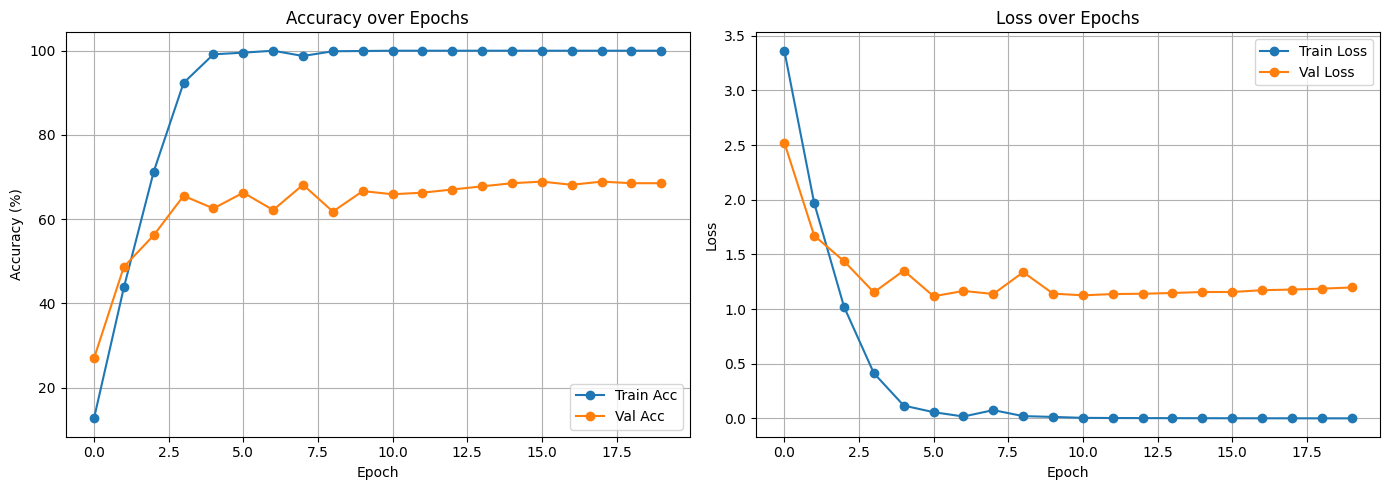


Training complete! Best validation accuracy: 68.91%


In [ ]:
# CELL 1: Mount + Load data
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import TimesformerForVideoClassification
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data (memory mapped)
train_X = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/train_X.npz', mmap_mode='r')['data']
test_X  = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/test_X.npz',  mmap_mode='r')['data']
train_y = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/train_y.npy')
test_y  = np.load('/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/test_y.npy')

print("Train:", train_X.shape, train_y.shape)  # (1786, 1, 9, 260, 346)
print("Test: ", test_X.shape,  test_y.shape)   # (544, 1, 9, 260, 346)

# ==================== FRAME FILTERING FUNCTION ====================
def find_most_dissimilar_frame(clip):
    T = clip.shape[0]
    if T <= 8:
        return None
    dissimilarities = []
    for t in range(1, T):
        prev = clip[t-1].flatten()
        curr = clip[t].flatten()
        mse = np.mean((prev - curr) ** 2)
        dissimilarities.append((t, mse))
    return max(dissimilarities, key=lambda x: x[1])[0] if dissimilarities else None

# ==================== DATASET CLASS (9 → 8 frames) ====================
class VideoDataset(Dataset):
    def __init__(self, X, y, remove_dissimilar=True):
        self.X = X
        self.y = torch.from_numpy(y.astype('int64'))
        self.remove_dissimilar = remove_dissimilar

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        clip = self.X[idx]
        if clip.ndim == 4 and clip.shape[0] == 1:
            clip = clip[0]  # (9, 260, 346)

        # Remove most dissimilar frame if enabled
        if self.remove_dissimilar and clip.shape[0] == 9:
            rm_idx = find_most_dissimilar_frame(clip)
            if rm_idx is not None:
                mask = np.ones(9, dtype=bool)
                mask[rm_idx] = False
                clip = clip[mask]

        clip = clip[:8]  # Ensure exactly 8 frames

        frames = []
        for t in range(8):
            frame = torch.from_numpy(clip[t]).unsqueeze(0).repeat(3, 1, 1)  # (3, H, W)
            frame = self.transform(frame)
            frames.append(frame)

        return torch.stack(frames), self.y[idx]  # (8, 3, 224, 224), label

# ==================== CREATE DATASETS ====================
full_train_dataset = VideoDataset(train_X, train_y, remove_dissimilar=True)
test_dataset       = VideoDataset(test_X,  test_y,  remove_dissimilar=True)

# Proper Train / Validation Split (e.g., 85% train, 15% val)
val_size = int(0.15 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Reproducible
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")
print(f"Test  samples: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# ==================== MODEL & TRAINING SETUP ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=50,
    ignore_mismatched_sizes=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
scaler = GradScaler()

save_path = "/content/drive/MyDrive/DL_by_Dr_hashir/THU_EACT_50_CHL_Ready/TimeSformer_FILTERED_BEST.pth"

# History tracking
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":  [], "val_acc":   []
}
best_val_acc = 0.0

print("\n" + "="*70)
print("TRAINING STARTS NOW (Proper Train/Val Split + Loss Tracking)")
print("="*70)

# ==================== TRAINING LOOP ====================
for epoch in range(20):  # You can increase epochs now that we have real validation
    # --- Training ---
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1:02d} [TRAIN]"):
        videos = videos.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type='cuda'):
            outputs = model(pixel_values=videos)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct / total
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc=f"Epoch {epoch+1:02d} [VAL]", leave=False):
            videos = videos.to(device)
            labels = labels.to(device)

            with autocast(device_type='cuda'):
                outputs = model(pixel_values=videos)
                loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"   NEW BEST MODEL SAVED! ({best_val_acc:.2f}%)\n")

# ==================== PLOTTING RESULTS ====================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_acc'], 'o-', label='Train Acc')
ax1.plot(history['val_acc'],   'o-', label='Val Acc')
ax1.set_title("Accuracy over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_loss'], 'o-', label='Train Loss')
ax2.plot(history['val_loss'],   'o-', label='Val Loss')
ax2.set_title("Loss over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")


Loaded best model for evaluation!


Testing: 100%|██████████| 136/136 [01:09<00:00,  1.96it/s]



Classification Report
              precision    recall  f1-score   support

           0     0.6923    0.7500    0.7200        12
           1     0.3810    0.6667    0.4848        12
           2     0.5000    0.4167    0.4545        12
           3     0.5455    0.5000    0.5217        12
           4     1.0000    1.0000    1.0000         3
           5     0.8000    1.0000    0.8889         8
           6     0.7000    0.5833    0.6364        12
           7     0.7647    0.8125    0.7879        16
           8     0.4167    0.4167    0.4167        12
           9     0.5714    0.3333    0.4211        12
          10     1.0000    0.7500    0.8571        12
          11     0.8333    0.8333    0.8333        12
          12     0.8824    0.9375    0.9091        16
          13     0.8182    0.7500    0.7826        12
          14     0.3333    0.4167    0.3704        12
          15     0.3750    0.2500    0.3000        12
          16     1.0000    0.6923    0.8182        13
    

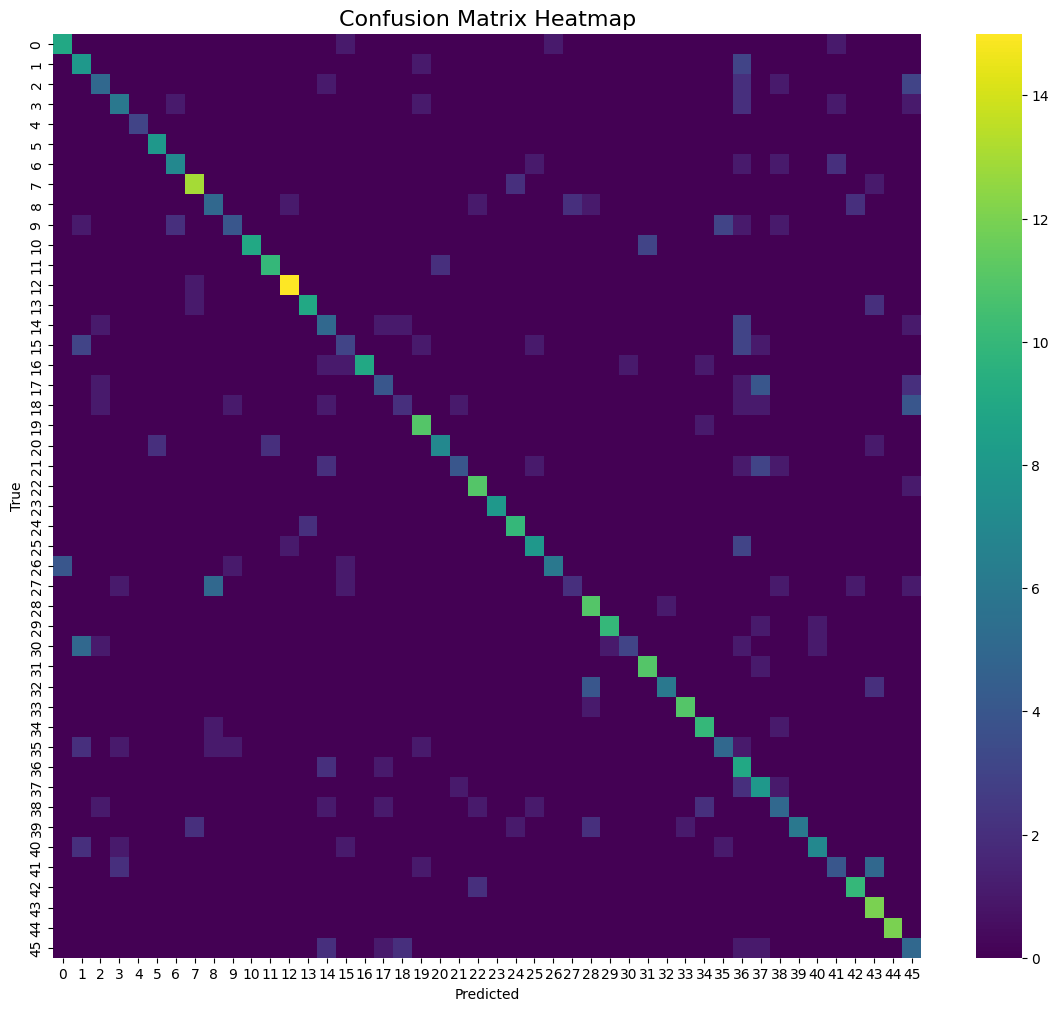


Confusion Matrix Shape: (46, 46)


In [ ]:
# ==================== LOAD BEST MODEL ====================
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

print("\nLoaded best model for evaluation!")

# ==================== TEST LOOP ====================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Testing"):
        videos = videos.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=videos)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ==================== CLASSIFICATION REPORT ====================
print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(all_labels, all_preds, digits=4))

# ==================== CONFUSION MATRIX ====================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="viridis")
plt.title("Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nConfusion Matrix Shape:", cm.shape)
